<a href="https://colab.research.google.com/github/ImDarkWarrior/Machine-Learning/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Dispositivo: cpu
Usaré este directorio como raíz de ImageFolder:
/content/drive/MyDrive/Gatos
Subcarpetas (clases) encontradas: ['Random', 'Gatos']
Clases encontradas por ImageFolder: ['Gatos', 'Random']
Número total de imágenes: 2000
Diccionario conceptual (0/1): {0: 'gato', 1: 'otros'}
Mapeo índice real -> nombre: {0: 'gato', 1: 'otros'}
Tamaño train: 1400
Tamaño val  : 300
Tamaño test : 300
SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  

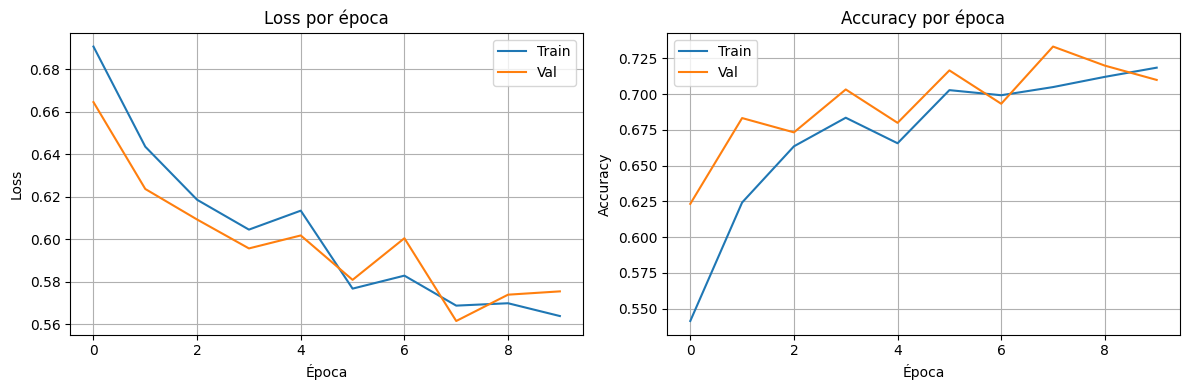


RESULTADOS EN TEST:
Loss test: 0.5610
Accuracy test: 0.7333


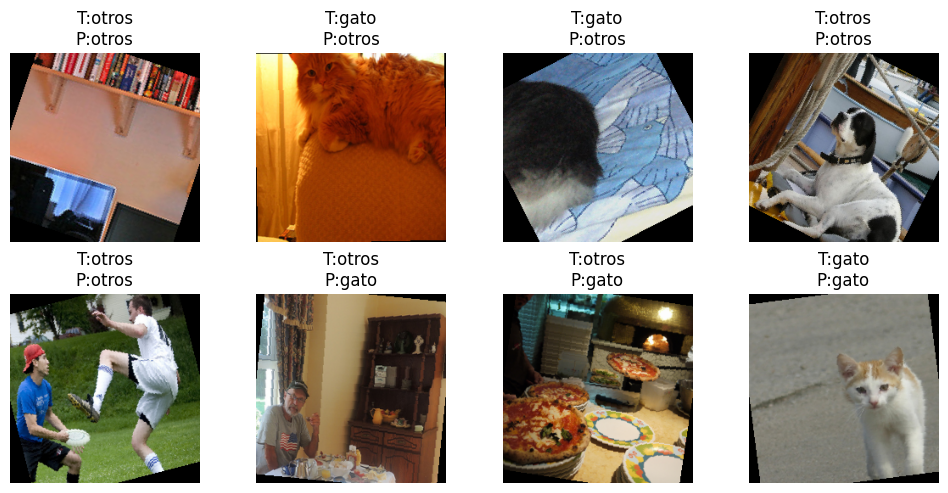

In [2]:
# ============================================
# 1. Importar librerías
# ============================================
import os

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Dispositivo:", device)

# ============================================
# 2. Configurar el directorio de imágenes desde Google Drive
# ============================================
# La carpeta 'Gatos' en tu Drive debe contener las subcarpetas de clases (ej. 'Gatos', 'Random')
dataset_dir = '/content/drive/MyDrive/Gatos'

# Verificar si el directorio existe y contiene subcarpetas
if not os.path.isdir(dataset_dir):
    raise RuntimeError(
        f"El directorio '{dataset_dir}' no existe. "
        "Asegúrate de que Google Drive esté montado y la ruta sea correcta."
    )

class_subfolders = [
    d for d in os.listdir(dataset_dir)
    if os.path.isdir(os.path.join(dataset_dir, d)) and not d.startswith('.')
]
if len(class_subfolders) < 2:
    raise RuntimeError(
        f"No se encontraron suficientes subcarpetas de clases en '{dataset_dir}'. "
        "Debe contener al menos dos subcarpetas (ej. 'Gatos', 'Random')."
    )

print("Usaré este directorio como raíz de ImageFolder:")
print(dataset_dir)
print("Subcarpetas (clases) encontradas:", class_subfolders)

# ======================================================
# 3. Transformaciones (preprocesamiento)
#    RandomResizedCrop, RandomRotation,
#    RandomHorizontalFlip, ToTensor, Normalize
# ======================================================
transformaciones = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225)
    )
])

# ============================================
# 4. Cargar dataset con ImageFolder
# ============================================
dataset = datasets.ImageFolder(root=dataset_dir,
                               transform=transformaciones)

print("Clases encontradas por ImageFolder:", dataset.classes)
print("Número total de imágenes:", len(dataset))

# -------------------------------------------------
# Diccionarios de clases
#   1) Conceptual: 0 -> gato, 1 -> otros  (pauta)
#   2) Real: índice interno PyTorch -> "gato"/"otros"
# -------------------------------------------------
clases_binarias = {0: "gato", 1: "otros"}
print("Diccionario conceptual (0/1):", clases_binarias)

class_to_idx = dataset.class_to_idx  # ej. {'Gatos': 0, 'Random': 1}
label_to_name = {}
cat_idx = None

for cls_name, idx in class_to_idx.items():
    if 'gat' in cls_name.lower():    # buscamos la carpeta del gato
        cat_idx = idx
        label_to_name[idx] = 'gato'
    else:
        label_to_name[idx] = 'otros'

if cat_idx is None:
    items_sorted = sorted(class_to_idx.items(), key=lambda x: x[1])
    label_to_name[items_sorted[0][1]] = 'gato'
    label_to_name[items_sorted[1][1]] = 'otros'

print("Mapeo índice real -> nombre:", label_to_name)

# ============================================
# 5. Dividir en entrenamiento, validación y prueba
#    70% train, 15% val, 15% test
# ============================================
len_dataset = len(dataset)
len_train   = int(len_dataset * 0.7)
len_temp    = len_dataset - len_train
len_val     = len_temp // 2
len_test    = len_temp - len_val

train_ds, val_ds, test_ds = random_split(
    dataset,
    (len_train, len_val, len_test),
    generator=torch.Generator().manual_seed(42)
)

print(f"Tamaño train: {len(train_ds)}")
print(f"Tamaño val  : {len(val_ds)}")
print(f"Tamaño test : {len(test_ds)}")

# ============================================
# 6. DataLoaders (ligeramente optimizados)
# ============================================
batch_size = 32
pin_memory = device.type == "cuda"

train_loader = DataLoader(
    train_ds, batch_size=batch_size, shuffle=True,
    num_workers=2, pin_memory=pin_memory
)
val_loader = DataLoader(
    val_ds, batch_size=batch_size, shuffle=False,
    num_workers=2, pin_memory=pin_memory
)
test_loader = DataLoader(
    test_ds, batch_size=batch_size, shuffle=False,
    num_workers=2, pin_memory=pin_memory
)

# ============================================
# 7. Definir una CNN simple
# ============================================
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),          # 224 -> 112

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),          # 112 -> 56

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),          # 56 -> 28
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 28 * 28, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

num_classes = len(dataset.classes)  # debería ser 2
model = SimpleCNN(num_classes=num_classes)

# === NUEVO: envolver en DataParallel si hay varias GPUs ===
if device.type == "cuda" and torch.cuda.device_count() > 1:
    print(f"Usando {torch.cuda.device_count()} GPUs con DataParallel")
    model = nn.DataParallel(model)

# mover (el módulo o DataParallel) al dispositivo
model = model.to(device)

print(model)

# ============================================
# 8. Pérdida y optimizador
# ============================================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# ============================================
# 9. Funciones de entrenamiento y evaluación
# ============================================
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in loader:
        images = images.to(device, non_blocking=pin_memory)
        labels = labels.to(device, non_blocking=pin_memory)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_size_local = labels.size(0)
        running_loss += loss.item() * batch_size_local
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total   += batch_size_local

    return running_loss / total, correct / total

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device, non_blocking=pin_memory)
            labels = labels.to(device, non_blocking=pin_memory)

            outputs = model(images)
            loss = criterion(outputs, labels)

            batch_size_local = labels.size(0)
            running_loss += loss.item() * batch_size_local
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total   += batch_size_local

    return running_loss / total, correct / total

# ============================================
# 10. Entrenamiento
# ============================================
num_epochs = 10
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc     = evaluate(model, val_loader, criterion, device)

    train_losses.append(train_loss);  val_losses.append(val_loss)
    train_accs.append(train_acc);    val_accs.append(val_acc)

    print(f"Época {epoch+1}/{num_epochs} "
          f"- Loss train: {train_loss:.4f}, Acc train: {train_acc:.4f} "
          f"- Loss val: {val_loss:.4f}, Acc val: {val_acc:.4f}")

# ============================================
# 11. Gráficas de loss y accuracy
# ============================================
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(train_losses, label="Train")
plt.plot(val_losses,   label="Val")
plt.title("Loss por época")
plt.xlabel("Época"); plt.ylabel("Loss")
plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(train_accs, label="Train")
plt.plot(val_accs,   label="Val")
plt.title("Accuracy por época")
plt.xlabel("Época"); plt.ylabel("Accuracy")
plt.legend(); plt.grid(True)

plt.tight_layout()
plt.show()

# ============================================
# 12. Evaluación en conjunto de prueba
# ============================================
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"\nRESULTADOS EN TEST:")
print(f"Loss test: {test_loss:.4f}")
print(f"Accuracy test: {test_acc:.4f}")

# ============================================
# 13. Mostrar algunas predicciones de ejemplo
# ============================================
def imshow_tensor(img_tensor):
    img = img_tensor.clone().cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis("off")

model.eval()
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

plt.figure(figsize=(10,5))
for i in range(min(8, images.size(0))):
    plt.subplot(2,4,i+1)
    imshow_tensor(images[i])
    true_label = label_to_name[int(labels[i].cpu())]
    pred_label = label_to_name[int(preds[i].cpu())]
    plt.title(f"T:{true_label}\nP:{pred_label}")
plt.tight_layout()
plt.show()
